In [13]:
import os
import pickle
from PIL import Image
import numpy as np

# Define paths for the input `.p` files and output folders
selected_data_all_path = "selected_data_1000"
poisoned_data_all_path = "poisoned_data_1000"
selected_images_path = "selected_images"
poisoned_images_path = "poisoned_images"

# Create output directories if they don't exist
os.makedirs(selected_images_path, exist_ok=True)
os.makedirs(poisoned_images_path, exist_ok=True)

def extract_and_save_images(source_path, target_folder):
    """
    Extract images from .p files and save them to the target folder.
    """
    for file in os.listdir(source_path):
        if file.endswith(".p"):
            with open(os.path.join(source_path, file), "rb") as f:
                data = pickle.load(f)
                img = data["img"]  # Assuming the key for the image is 'img'
                
                # Convert numpy array to PIL Image if necessary
                if isinstance(img, np.ndarray):
                    img = Image.fromarray(img)
                
                # Save the image with a unique name
                img_save_path = os.path.join(target_folder, f"{os.path.splitext(file)[0]}.png")
                img.save(img_save_path, "PNG")
                print(f"Saved: {img_save_path}")

# Extract and save images from selected_data_all
print("Extracting images from selected_data_all...")
extract_and_save_images(selected_data_all_path, selected_images_path)

# Extract and save images from poisoned_data_all
print("Extracting images from poisoned_data_all...")
extract_and_save_images(poisoned_data_all_path, poisoned_images_path)

print("Image extraction and saving completed!")


Extracting images from selected_data_all...
Saved: selected_images\0.png
Extracting images from poisoned_data_all...
Saved: poisoned_images\0.png
Image extraction and saving completed!



Similarity scores for the image:
  a cat: 0.2104
  a dog: 0.2615


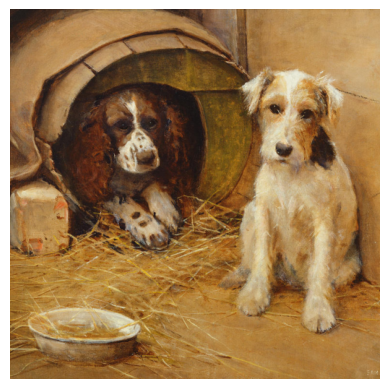

In [29]:
import torch
import clip
from PIL import Image
import pickle
import matplotlib.pyplot as plt

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load the poisoned pickle file
with open('selected_data/0.p', 'rb') as f:
    poisoned_data = pickle.load(f)

# Extract the image and associated text from the pickle file
img = Image.fromarray(poisoned_data['img'])
text_from_pickle = poisoned_data['text']

# Preprocess the image
poisoned_image = preprocess(img).unsqueeze(0).to(device)

# Define a list of possible text labels
text_labels = ["a cat", "a dog"]
text_inputs = clip.tokenize(text_labels).to(device)

# Encode the image and text using CLIP
with torch.no_grad():
    poisoned_features = model.encode_image(poisoned_image)
    text_features = model.encode_text(text_inputs)

# Normalize the features for cosine similarity
poisoned_features /= poisoned_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute similarity scores
poisoned_similarity = (poisoned_features @ text_features.T).squeeze()

# Print similarity scores for each label
print("\nSimilarity scores for the image:")
for i, label in enumerate(text_labels):
    print(f"  {label}: {poisoned_similarity[i].item():.4f}")

# Display the image with the associated text from the pickle file
plt.imshow(img)
plt.axis('off')
# plt.title(f"Pickle Text: {text_from_pickle}")
plt.show()


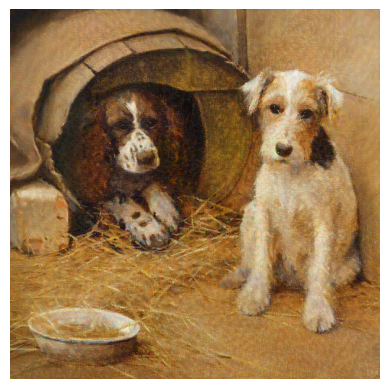

Similarity scores for the image:
  a cat: 0.2113
  a dog: 0.2607


In [26]:
import torch
import clip
from PIL import Image
import pickle
import matplotlib.pyplot as plt

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load the poisoned pickle file
with open('poisoned_data_1000/0.p', 'rb') as f:
    poisoned_data = pickle.load(f)

# Extract the image and associated text
img = poisoned_data['img']  # Already a PIL image
text_from_pickle = poisoned_data['text']

# Display the image and text
plt.imshow(img)
plt.axis('off')
# plt.title(text_from_pickle)
plt.show()

# Preprocess the image for CLIP
image_tensor = preprocess(img).unsqueeze(0).to(device)

# Define possible text labels
text_labels = ["a cat", "a dog"]
text_inputs = clip.tokenize(text_labels).to(device)

# Encode the image and text using CLIP
with torch.no_grad():
    image_features = model.encode_image(image_tensor)
    text_features = model.encode_text(text_inputs)

# Normalize the features for cosine similarity
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute similarity scores
similarity = (image_features @ text_features.T).squeeze()

# Print similarity scores for each label
print("Similarity scores for the image:")
for i, label in enumerate(text_labels):
    print(f"  {label}: {similarity[i].item():.4f}")


Similarity scores for the image:
  a cat: 0.2135
  a dog: 0.2607
  a car: 0.1818
  a tree: 0.1658
  a house: 0.2209
  
Similarity scores for the image:
  a cat: 0.2112
  a dog: 0.2590
  a car: 0.1812
  a tree: 0.1624
  a house: 0.2190

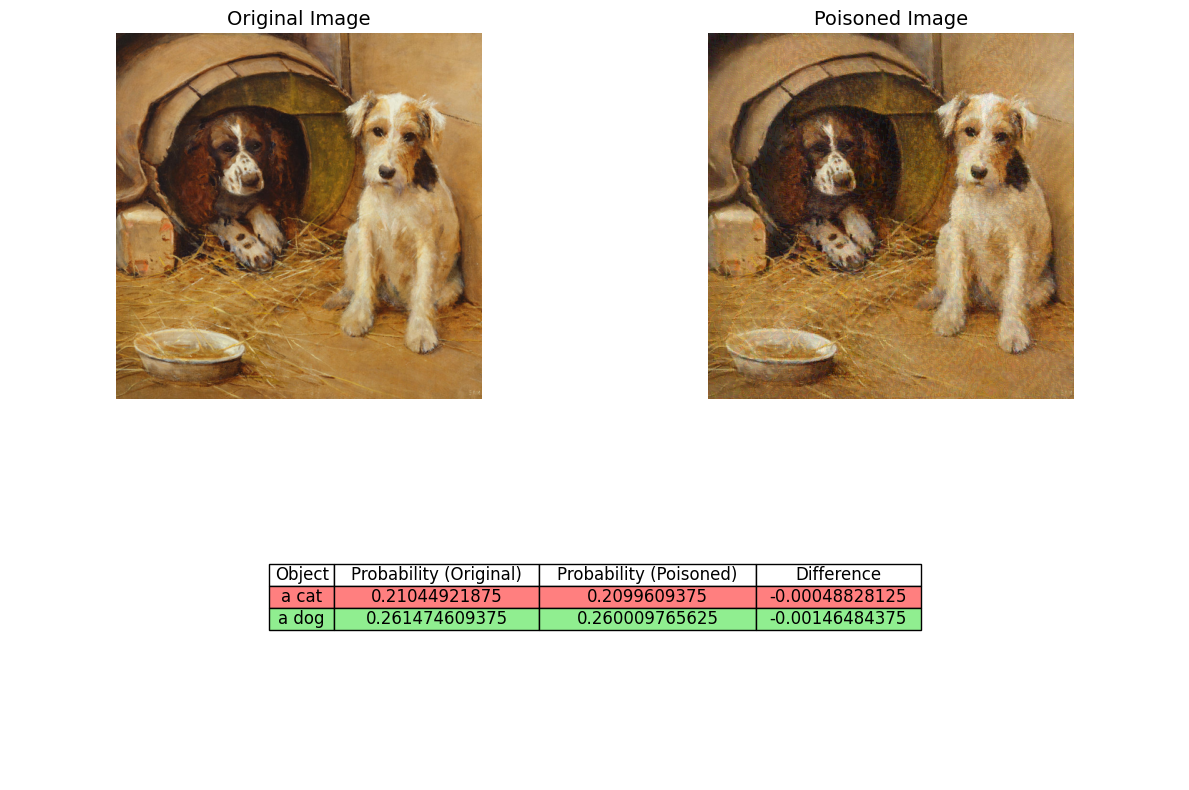

In [41]:
import torch
import clip
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to process and analyze a pickle file
def process_pickle_file(pickle_path, text_labels):
    # Load the pickle file
    with open(pickle_path, 'rb') as f:
        poisoned_data = pickle.load(f)

    # Extract the image
    if isinstance(poisoned_data['img'], Image.Image):
        img = poisoned_data['img']
    else:
        img = Image.fromarray(poisoned_data['img'])

    # Preprocess the image for CLIP
    image_tensor = preprocess(img).unsqueeze(0).to(device)

    # Tokenize the text labels for CLIP
    text_inputs = clip.tokenize(text_labels).to(device)

    # Encode the image and text using CLIP
    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        text_features = model.encode_text(text_inputs)

    # Normalize the features for cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute similarity scores
    similarity_scores = (image_features @ text_features.T).squeeze()

    return img, similarity_scores.tolist()

# Define text labels
text_labels = ["a cat", "a dog"]

# Process pickle files
original_img, original_scores = process_pickle_file('selected_data/0.p', text_labels)
poisoned_img, poisoned_scores = process_pickle_file('poisoned_data_3000/0.p', text_labels)

# Create a DataFrame to store probabilities and differences
data = {
    "Object": text_labels,
    "Probability (Original)": original_scores,
    "Probability (Poisoned)": poisoned_scores,
    "Difference": [poisoned - original for original, poisoned in zip(original_scores, poisoned_scores)],
}
df = pd.DataFrame(data)

# Add a color column based on the conditions
def color_conditions(row):
    if row["Object"] == "a cat":
        return "green" if row["Difference"] > 0 else "red"
    elif row["Object"] == "a dog":
        return "green" if row["Difference"] < 0 else "red"
    return "white"

df["Color"] = df.apply(color_conditions, axis=1)

# Plot images and the table side by side
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)

# Display original image
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(original_img)
ax1.axis('off')
ax1.set_title("Original Image", fontsize=14)

# Display poisoned image
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(poisoned_img)
ax2.axis('off')
ax2.set_title("Poisoned Image", fontsize=14)

# Display the table
ax3 = fig.add_subplot(gs[1, :])
ax3.axis('off')

# Format and color the table
colors = df["Color"].map({"green": "#90EE90", "red": "#FF7F7F", "white": "#FFFFFF"})
table = ax3.table(
    cellText=df[["Object", "Probability (Original)", "Probability (Poisoned)", "Difference"]].values,
    colLabels=["Object", "Probability (Original)", "Probability (Poisoned)", "Difference"],
    loc="center",
    cellLoc="center",
)

# Apply cell background colors
for i in range(len(df)):
    for j in range(4):  # Apply color to all cells in the row
        table[(i + 1, j)].set_facecolor(colors.iloc[i])

# Adjust table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(df.columns))))

plt.tight_layout()
plt.show()


In [ ]:
import torch
import clip
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
import numpy as np
import os

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to process and analyze a pickle file
def process_pickle_file(pickle_path, text_labels):
    # Load the pickle file
    with open(pickle_path, 'rb') as f:
        poisoned_data = pickle.load(f)

    # Extract the image
    if isinstance(poisoned_data['img'], Image.Image):
        img = poisoned_data['img']
    else:
        img = Image.fromarray(poisoned_data['img'])

    # Preprocess the image for CLIP
    image_tensor = preprocess(img).unsqueeze(0).to(device)

    # Tokenize the text labels for CLIP
    text_inputs = clip.tokenize(text_labels).to(device)

    # Encode the image and text using CLIP
    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        text_features = model.encode_text(text_inputs)

    # Normalize the features for cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute similarity scores
    similarity_scores = (image_features @ text_features.T).squeeze()

    # Convert similarities to probabilities using softmax
    probabilities = torch.softmax(similarity_scores, dim=0)

    return img, probabilities.tolist()

# Define text labels
text_labels = ["a cat", "a dog"]

# Directory paths
selected_dir = 'selected_data'
poisoned_dir = 'poisoned_data_500'

# Gather file paths
selected_files = sorted([os.path.join(selected_dir, f) for f in os.listdir(selected_dir)])
poisoned_files = sorted([os.path.join(poisoned_dir, f) for f in os.listdir(poisoned_dir)])

# Ensure the number of files matches
assert len(selected_files) == len(poisoned_files), "Mismatch in the number of files between selected and poisoned data."

# Loop through files and process
fig = plt.figure(figsize=(15, len(selected_files) * 6))
gs = GridSpec(len(selected_files), 2, figure=fig)

all_data = []

for i, (selected_file, poisoned_file) in enumerate(zip(selected_files, poisoned_files)):
    # Process files
    original_img, original_probs = process_pickle_file(selected_file, text_labels)
    poisoned_img, poisoned_probs = process_pickle_file(poisoned_file, text_labels)
    
    # Create a DataFrame to store probabilities and differences
    data = {
        "Object": text_labels,
        "Probability (Original)": original_probs,
        "Probability (Poisoned)": poisoned_probs,
        "Difference": [poisoned - original for original, poisoned in zip(original_probs, poisoned_probs)],
    }
    df = pd.DataFrame(data)

    # Add to overall data
    all_data.append((selected_file, poisoned_file, df))
    
    # Display images side by side
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.imshow(original_img)
    ax1.axis('off')
    ax1.set_title(f"Original: {os.path.basename(selected_file)}", fontsize=12)

    ax2 = fig.add_subplot(gs[i, 1])
    ax2.imshow(poisoned_img)
    ax2.axis('off')
    ax2.set_title(f"Poisoned: {os.path.basename(poisoned_file)}", fontsize=12)

plt.tight_layout()
plt.show()

# Display tables for all files
for selected_file, poisoned_file, df in all_data:
    print(f"\nComparison for files:\nOriginal: {os.path.basename(selected_file)}\nPoisoned: {os.path.basename(poisoned_file)}")
    print(df)


AssertionError: Mismatch in the number of files between selected and poisoned data.

In [8]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# Prepare the final formatted DataFrame
formatted_data = []

for selected_file, poisoned_file, df in all_data:
    for _, row in df.iterrows():
        formatted_data.append({
            "Object": row["Object"],
            "Probability (Original)": row["Probability (Original)"],
            "Probability (Poisoned)": row["Probability (Poisoned)"],
            "Difference": row["Difference"],
            "File Pair": f"{os.path.basename(selected_file)} -> {os.path.basename(poisoned_file)}"
        })

# Create a DataFrame
final_df = pd.DataFrame(formatted_data)

# Define colors for the conditions
def highlight_cell(val, column, object_type):
    if object_type == "a cat" and column == "Difference":
        return "background-color: green" if val > 0 else "background-color: red"
    elif object_type == "a dog" and column == "Difference":
        return "background-color: green" if val < 0 else "background-color: red"
    return ""

# Apply styling to the DataFrame
def style_table(df):
    styled_df = df.style.apply(
        lambda x: [
            highlight_cell(x["Difference"], "Difference", x["Object"]) for i in x
        ],
        axis=1,
    )
    return styled_df

# Display the table in the required format
final_df_pivot = final_df.pivot_table(
    index="File Pair", columns="Object", values=["Probability (Original)", "Probability (Poisoned)", "Difference"]
)
display(final_df_pivot.style.set_caption("Image Comparisons: Probability and Differences").background_gradient(axis=None))
